## Text Analysis Task 2A

### 0. Prepare 100 documents

In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.graphics', 'rec.motorcycles', 'sci.space', ]
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

data = dataset.data[:1000]
labels = dataset.target[:1000]
print("Original document:\n")
print(data[0])
for i in range(len(data)):
    data[i] = data[i].split()
print("\nDocument after spliting:\n")
print(data[0])

Original document:

From: da709@cleveland.Freenet.Edu (Stephen Amadei)
Subject: Project Help
Organization: Case Western Reserve University, Cleveland, Ohio (USA)
Lines: 17
NNTP-Posting-Host: hela.ins.cwru.edu


Hello, 
 
I am new to this news group, but I need some info.  I am 
currently doing a project for a class on the Internet.  I am
looking for good sources of information on space and astronomy,
more notably, our own solar system.  If anyone knows any good
sites where I can get information about this kinda stuff, please 
e-mail me at STK1663@VAX003.STOCKTON.EDU.  Thanx.
 
                                ----Steve
 
(my newsreader doesn't have a .sig yet, sorry.)
-- 
Please Address repondes to Stk1600@Vax003.Stockton.Edu
                                     or
                           Adonchey@Faatcrl.Faa.Gov


Document after spliting:

['From:', 'da709@cleveland.Freenet.Edu', '(Stephen', 'Amadei)', 'Subject:', 'Project', 'Help', 'Organization:', 'Case', 'Western', 'Reserve', 'Un

### 1. Data preprocessing

In [2]:
import nltk
from nltk.corpus import wordnet as wn

en_stop = nltk.corpus.stopwords.words('english')

en_stop = ["``","/",",.",".,",";","--",":",")","(",'"','&',"'",'),',',"','-','.,','.,"','.-',"?",">","<"]                  \
         + ["0","1","2","3","4","5","6","7","8","9","10","11","12","86","1986","1987","000"]                                                      \
         + ["said","say","u","v","mln","ct","net","dlrs","tonne","pct","shr","nil","company","lt","share","year","billion","price"]          \
         + en_stop

def preprocess_word(word, stopwordset):
    
    #1.convert words to lowercase
    word=word.lower()
    
    #2.remove "," and "."
    if word in [",","."]:
        return None
    
    #3.remove stopwords
    if word in stopwordset:
        return None
    for st in [",",".","``","/",",.",".,",";","--",":",")","(",'"','&',"'",'),',',"','-','.,','.,"','.-',"?",">","<"]:
        if st in word:
            word = word.replace(st, '')
    
    #4.lemmatize
    lemma = wn.morphy(word)
    if lemma is None:
        return word

    # lemmatized words could be in the stopwords set
    elif lemma in stopwordset: 
        return None
    else:
        return lemma
    

def preprocess_document(document):
    document=[preprocess_word(w, en_stop) for w in document]
    document=[w for w in document if w is not None]
    return document

def preprocess_documents(documents):
    return [preprocess_document(document) for document in documents]

### 2. Clustering

### 1) Document vectorization with HashingVectorizer and add IDF normalization on the output.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline

pre_data = preprocess_documents(data)
pre_data = [" ".join(doc) for doc in pre_data]

hasher = HashingVectorizer(n_features=5000, alternate_sign=False, norm=None)
vectorizer = make_pipeline(hasher, TfidfTransformer())
X = vectorizer.fit_transform(pre_data)


### 2) Use K-means to cluster documents. (Using euclidean distance)

In [13]:
from sklearn.cluster import KMeans

num_clusters = 2
km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=1000, n_init=1)

# fit
clusters = km.fit_predict(X)

### 3) Check out the clustering result.

In [14]:
import numpy as np

for doc, cls, label in zip(preprocess_documents(data)[:5], clusters[:5], labels[:5]):
    print(categories[label], cls, doc[:10])

sci.space 0 ['from', 'da709@clevelandfreenetedu', 'stephen', 'amadei', 'subject', 'project', 'help', 'organization', 'case', 'western']
sci.space 0 ['from', 'bday@lambdamsfcnasagov', 'brian', 'day', 'subject', 'hst', 'servicing', 'mission', 'schedule', 'days']
comp.graphics 0 ['from', 'tdawson@enginumichedu', 'chris', 'herringshaw', 'subject', 'wingcommanderii', 'graphics', 'organization', 'university', 'michigan']
sci.space 0 ['from', 'higgins@fnalffnalgov', 'bill', 'higgins', 'beam', 'jockey', 'subject', 'get', 'wa', 'comet']
rec.motorcycles 1 ['from', 'behanna@sylnjneccom', 'chris', 'behanna', 'subject', 'cobra', 'lock', 'organization', 'nec', 'system']


### 4) Evaluate the clustering results.

In [15]:
from sklearn import metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Homogeneity: 0.406
Completeness: 0.754
V-measure: 0.528
Adjusted Rand-Index: 0.392
Silhouette Coefficient: 0.005


### 5) Visualize the result of K-means.

C:\Users\iris\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\iris\miniconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(<Figure size 576x576 with 1 Axes>,
 [Text(-6.814497, -7.844874, '0'),
  Text(14.710056, 22.52478, '1'),
  Text(nan, nan, '2'),
  Text(nan, nan, '3'),
  Text(nan, nan, '4')])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


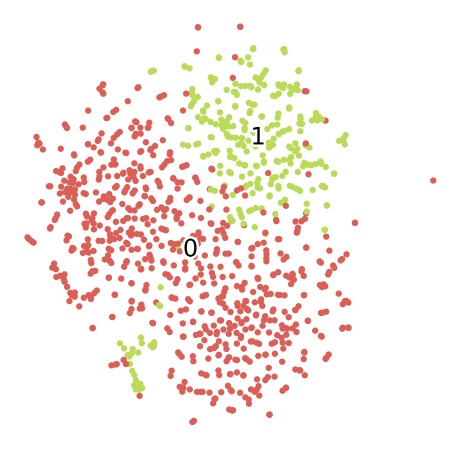

In [16]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

lower_dimension = TSNE(random_state=42).fit_transform(X)

def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", 5))
 
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
 
    txts = []
    for i in range(5):
        xtext, ytext = np.median(x[colors == i, :], axis=0)    #中心点
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"),PathEffects.Normal()])    #线条效果
        txts.append(txt)
    return f, ax, sc, txts
 
scatter(lower_dimension, clusters)